In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import imageio
import os
import multiprocess as mp
from scipy.optimize import curve_fit

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
t_max = 100
dt = .01
lam = 0.1931833275037836
N = 11

In [3]:
def init(N, L):
    r0 = np.zeros([N, 3])
    for i in range(N):
        r0[i] = np.array([i+1, 0, 0])
    
    p0 = np.zeros([N, 3])
    central_idx = -(-N//2)
    p0[central_idx] = np.array([-3/7., 6/7., -2/7.])
    
    return r0, p0

In [4]:
r0, p0 = init(N=11, L=11)

In [5]:
R, P, t = a.BABAB_Ndim(r0, p0, t_max, dt, f.chain_force, lam, 
                       thermal_noise=False, periodic={'PBC': True, 'box_size': 11, 'closed': False})

100%|██████████| 9999/9999 [00:06<00:00, 1520.15it/s]


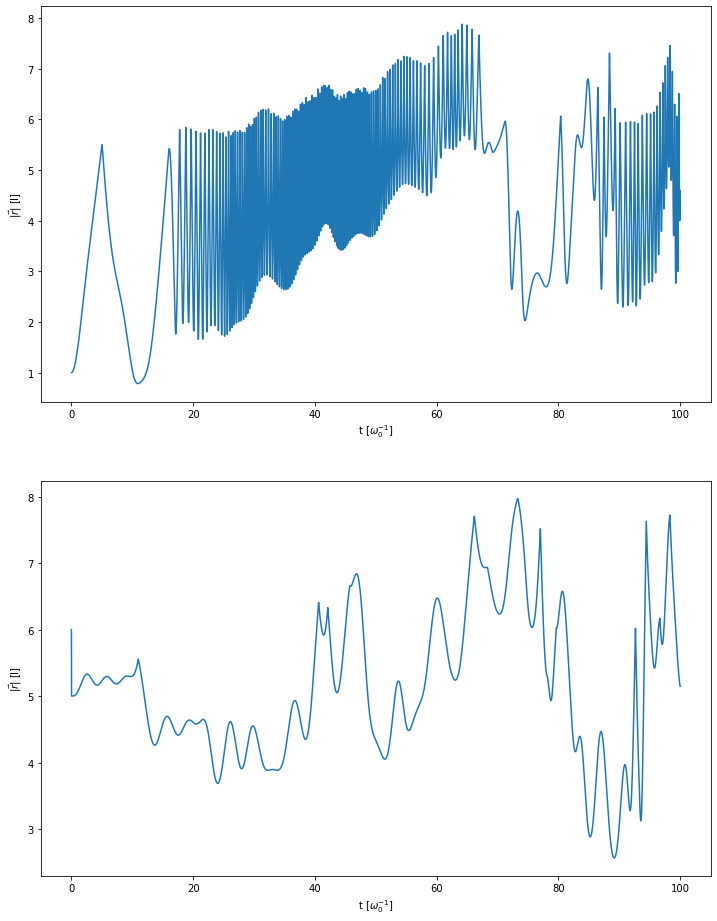

In [6]:
fig1, axes1 = plt.subplots(ncols=1, nrows=2, figsize=(12,16))
axes1[0].plot(t, np.linalg.norm(R[:,0,:], axis=1))
axes1[0].set_xlabel(r't $[\omega_0^{-1}]$')
axes1[0].set_ylabel(r'$|\vec{r}|$ [l]')

axes1[1].plot(t, np.linalg.norm(R[:,5,:], axis=1))
axes1[1].set_xlabel(r't $[\omega_0^{-1}]$')
axes1[1].set_ylabel(r'$|\vec{r}|$ [l]')
plt.show()

In [7]:
r0, p0 = init(N=11, L=11)

In [8]:
R_cl, P_cl, t_cl = a.BABAB_Ndim(r0, p0, t_max, dt, f.chain_force, lam, 
                                thermal_noise=False, periodic={'PBC': True, 'box_size': 11, 'closed': True})

100%|██████████| 9999/9999 [00:06<00:00, 1549.31it/s]


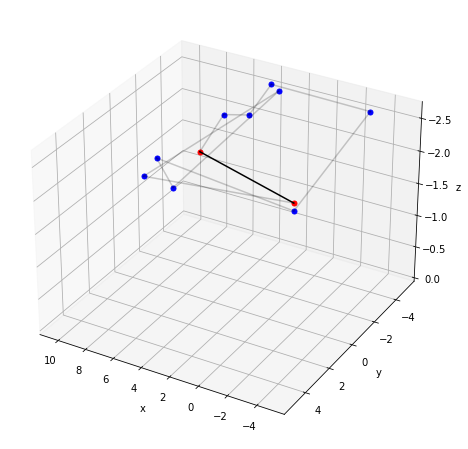

In [10]:
xlim = (R_cl[:,:,0].max(), R_cl[:,:,0].min())
ylim = (R_cl[:,:,1].max(), R_cl[:,:,1].min())
zlim = (R_cl[:,:,2].max(), R_cl[:,:,2].min())
files = []
for i in range(len(t_cl)):
    
    if i%100==0:
        plt.clf()
        fig = plt.figure(figsize=(12,8));
        ax = fig.add_subplot(111, projection='3d')
        for part_i, part in enumerate(R_cl[i]):
            if part_i==0:
                ax.plot(part[0], part[1], part[2], color='red', linestyle='', marker='o', markersize=5)
            elif part_i == N-1:
                ax.plot(part[0], part[1], part[2], color='red', linestyle='', marker='o', markersize=5)
            else:
                ax.plot(part[0], part[1], part[2], color='blue', linestyle='', marker='o', markersize=5)
        
        bonds = np.stack((R_cl[i][:-1], R_cl[i][1:]), axis=1)
        end2end = np.vstack((R_cl[i][-1], R_cl[i][0]))
        
        for b in bonds:
            ax.plot(b[:,0], b[:,1], b[:,2], linestyle='-', color='black', alpha=0.2)
        ax.plot(end2end[:,0], end2end[:,1], end2end[:,2], linestyle='-', color='black')
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
        
        filename = f'./figures/chain/frame_{int(i/100)}.png'
        plt.savefig(filename)
        files.append(filename)
        
        plt.draw()
        IPython.display.clear_output(wait=True)
        IPython.display.display(fig)
    plt.close()
IPython.display.clear_output(wait=True)

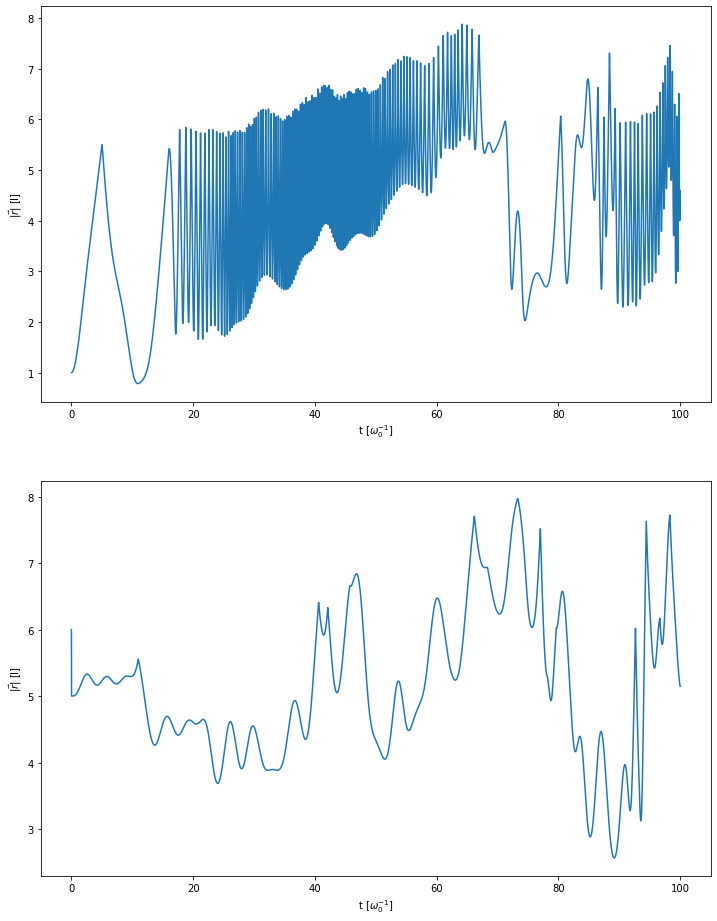

In [11]:
fig2, axes2 = plt.subplots(ncols=1, nrows=2, figsize=(12,16))
axes2[0].plot(t_cl, np.linalg.norm(R_cl[:,0,:], axis=1))
axes2[0].set_xlabel(r't $[\omega_0^{-1}]$')
axes2[0].set_ylabel(r'$|\vec{r}|$ [l]')

axes2[1].plot(t_cl, np.linalg.norm(R_cl[:,5,:], axis=1))
axes2[1].set_xlabel(r't $[\omega_0^{-1}]$')
axes2[1].set_ylabel(r'$|\vec{r}|$ [l]')
plt.show()

In [50]:
def calc_energy(r, p, k=1):
    V = (.5 * k * np.linalg.norm(r[1:] - r[:-1], axis=1)**2).sum()
    V += (.5 * k * np.linalg.norm(r[0] - r[-1])**2).sum()
    T = (np.linalg.norm(p, axis=1)**2 / 2.).sum()
    return T + V

In [52]:
E = np.zeros(len(t))
for i in range(len(t_cl)):
    E[i] = calc_energy(R[i], P[i])

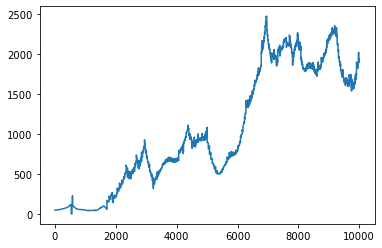

In [53]:
plt.plot(E)

In [12]:
m = np.ones([N, 1])

In [13]:
def centre_of_mass(r, m):
    M = m.sum()
    r_cm = np.zeros([r.shape[0], r.shape[2]])
    for i, r_i in enumerate(r):
        r_cm[i] = (m*r_i).sum(axis=0) / M
        
    return r_cm

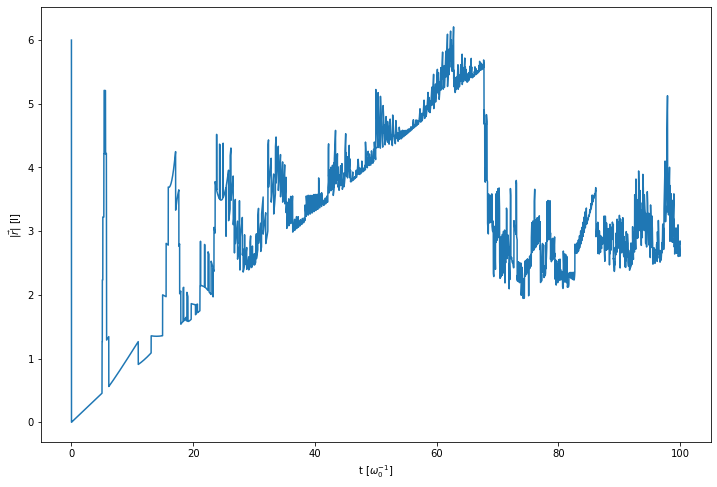

In [15]:
fig3, axes3 = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
axes3.plot(t, np.linalg.norm(centre_of_mass(R_cl, m), axis=1))
axes3.set_xlabel(r't $[\omega_0^{-1}]$')
axes3.set_ylabel(r'$|\vec{r}|$ [l]')
plt.show()